In [107]:
!pip install -q transformers datasets librosa

^C


In [ ]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt


**Рейтинг русских моделей** [ссылка](https://huggingface.co/spaces/mteb/leaderboard)

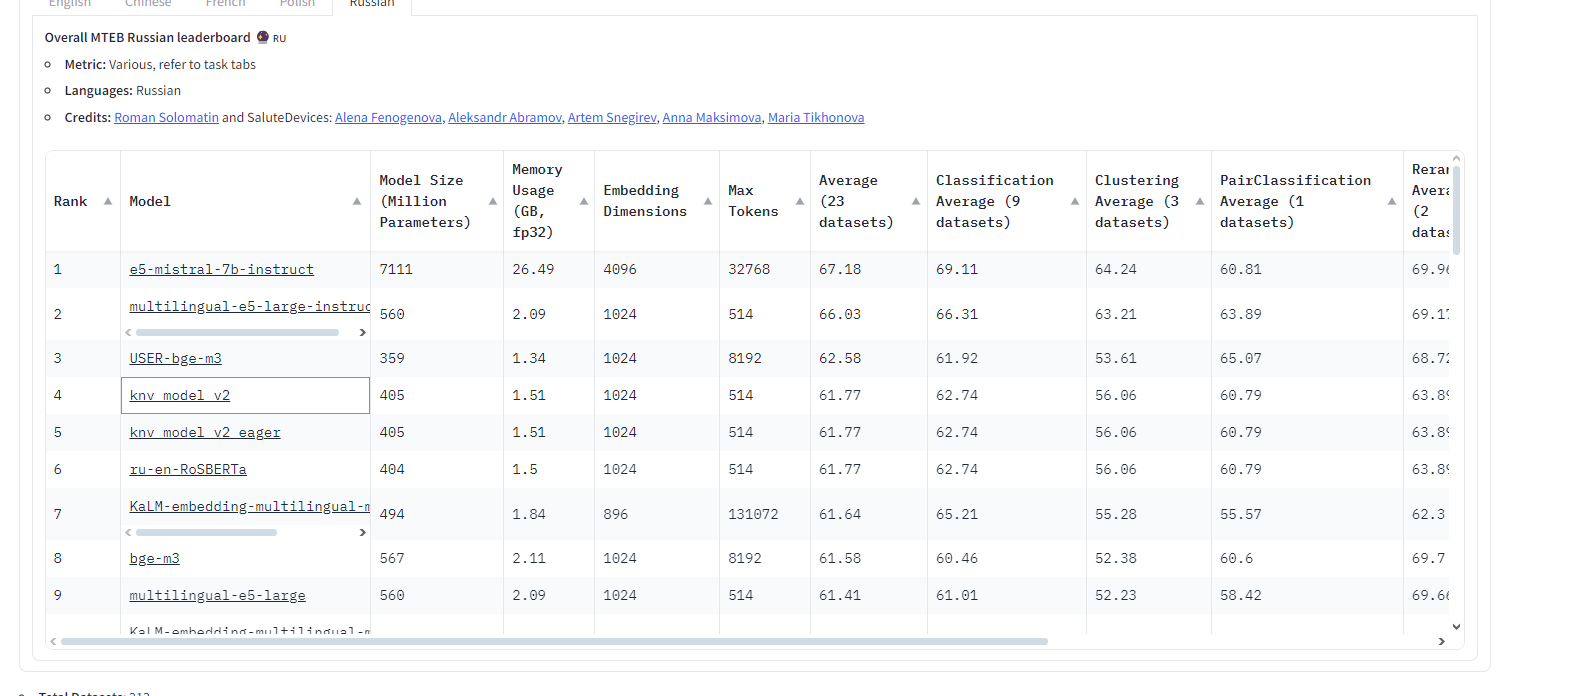

In [ ]:
# выбираем одну из моделей рейтинга
BASE_MODEL=	'ShakurovR/knv_model_v2'
EMBEDDING_DIM = 1024

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [ ]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={"train": "./content/train_plus_djacon.csv", "validation": "./content/valid.csv"})
data

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 69973
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [ ]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {']', '☺', '做', 'ё', '⠦', '.', '🙄', '🎖', '😊', '😡', '⡏', '⡀', 'Ч', '🤤', '🤭', 'U', 'Q', 'Ы', '\\', '🤯', '🖤', '–', '👐', '🙎', '⠈', '͓', '🍧', '💁', '⣀', '🇷', '—', 'К', 'c', '청', 'Ɲ', 'E', '̫', '⣦', '🌊', 'ь', '😗', '⠇', '😵', '😾', '͘', '🤨', '😜', '🤲', '！', '카', '👶', '😒', '⠻', '油', 'q', 'Е', '_', '⠾', '🦈', '병', '🤓', '͏', '💓', '̺', '😔', '⢿', '💍', '<', '🔑', '👋', '⠏', '⛑', '😪', '9', 'ň', '⚰', '😰', '…', 'ē', '🇫', '͠', '♫', '👩', '⡟', 'Ш', 'i', 'п', '？', '⢹', '°', '!', '💦', '🍕', '⡆', 'С', 'y', '😩', '🌟', '⣘', '̹', '🇭', 'г', 'W', '💄', '⠞', '⢰', '⢣', '“', '🤙', '⠄', '^', '🏊', '️', ' ', '🙂', '😣', '🐃', '💙', '💸', 'Ё', '🔪', '➡', 'у', 'Á', '🙊', '🏾', 'Ь', '🍁', '･', '👓', 'О', '🥺', '🦵', 'с', 'щ', '😤', '=', '⡼', '🦗', '̦', '👨', '⠘', '🤕', '💆', 'ʌ', '😳', '허', '😬', 'м', '🤮', '😸', '😠', '🌿', '̙', 'ᴜ', 'Г', '⠁', '🎣', '≈', 'n', '🇸', '💰', '❄', 'Ц', '?', '(', '⢤', '😏', '👍', '🎶', 'ɴ', '🥘', '🥂', '💛', '0', '🐕', '😧', 'э', '♥', 'я', 'ş', 'S', '⠛', 'ɪ', '▫', '⠃', '̷', '🤦', '⣤', '🍰', '🖕', '🤷', 'ω', '😶', '⛏', 

#### 📊 Построим гистограммы распределения

In [ ]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

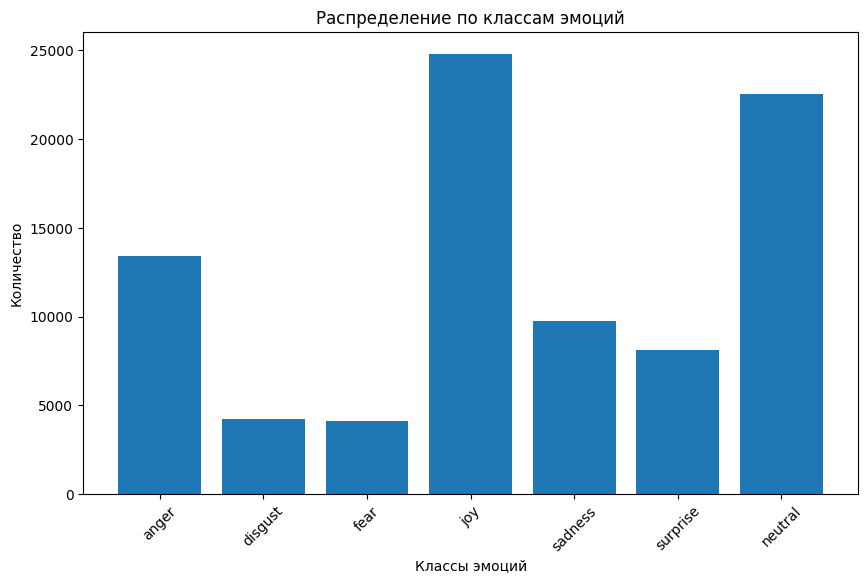

In [ ]:
plot_histogram(data["train"])

In [ ]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

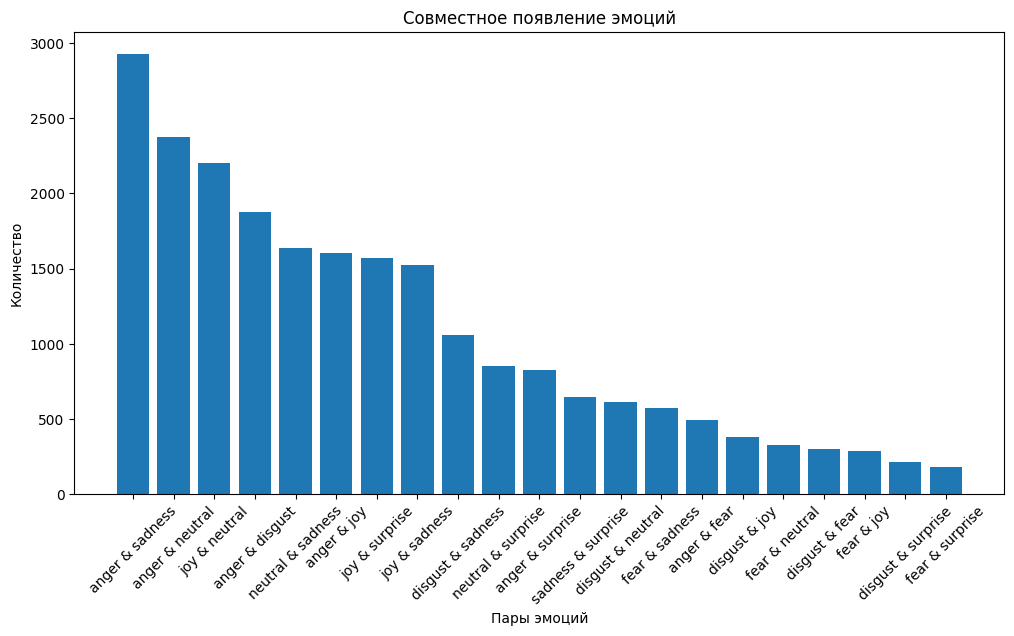

In [ ]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [ ]:
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

In [ ]:
data = data.map(cleaner)

In [ ]:
data["train"][3]

{'text': 'чтобы она почувствовала угрозу',
 'anger': 0,
 'disgust': 0,
 'fear': 1,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0}

#### 🏋️ Подготовим модель

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.hid = torch.nn.Linear(hidden_dim, 368)
        self.fc = torch.nn.Linear(368, num_classes)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.hid(features)
        output = self.fc(output)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(pretrained_model=BASE_MODEL, hidden_dim=EMBEDDING_DIM, num_classes=len(labels))
model = model.to(device)

#### 📒 Подготовим данные для обучения

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
max_len = 64

data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           return_token_type_ids=True,
                                           padding="max_length"), batched=True)

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [ ]:
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions

    return example

data = data.map(one_hot_to_list)
data["train"][9]["one_hot_labels"]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

[0, 0, 0, 0, 0, 0, 1]

#### 🔗 Dataset & DataLoader

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(self.dataset[index]["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

In [ ]:
train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

#### 🚀 Инициализируем функцию ошибки и оптимизатор

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001, weight_decay=0.)

#### 🥷 Код для обучения и валидации

In [ ]:
def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

    return model

In [ ]:
data['train']

Dataset({
    features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral', 'input_ids', 'token_type_ids', 'attention_mask', 'one_hot_labels'],
    num_rows: 69973
})

In [ ]:
def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

#### 🏃‍♂️‍➡️ Запускаем обучение

In [ ]:
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    model = train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

Epoch: 0


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Train loss: 0.3157817578212217
Valid loss: 0.2404645660344292
Epoch: 1
Train loss: 0.27434716554838734
Valid loss: 0.23012934695271886
Epoch: 2
Train loss: 0.2525469036108833
Valid loss: 0.23235432996469385


In [ ]:
outputs_, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs_) >= 0.5
print(metrics.classification_report(targets, outputs, target_names=labels,digits=4))

Valid loss: 0.23235432996469385
              precision    recall  f1-score   support

       anger     0.5604    0.4979    0.5273       717
     disgust     0.5000    0.4536    0.4757        97
        fear     0.4306    0.5905    0.4980       105
         joy     0.8187    0.8098    0.8142      2219
     sadness     0.5622    0.6949    0.6216       390
    surprise     0.6167    0.2837    0.3886       624
     neutral     0.6707    0.6031    0.6351      1766

   micro avg     0.6960    0.6375    0.6655      5918
   macro avg     0.5942    0.5619    0.5658      5918
weighted avg     0.6929    0.6375    0.6573      5918
 samples avg     0.6556    0.6551    0.6461      5918



c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


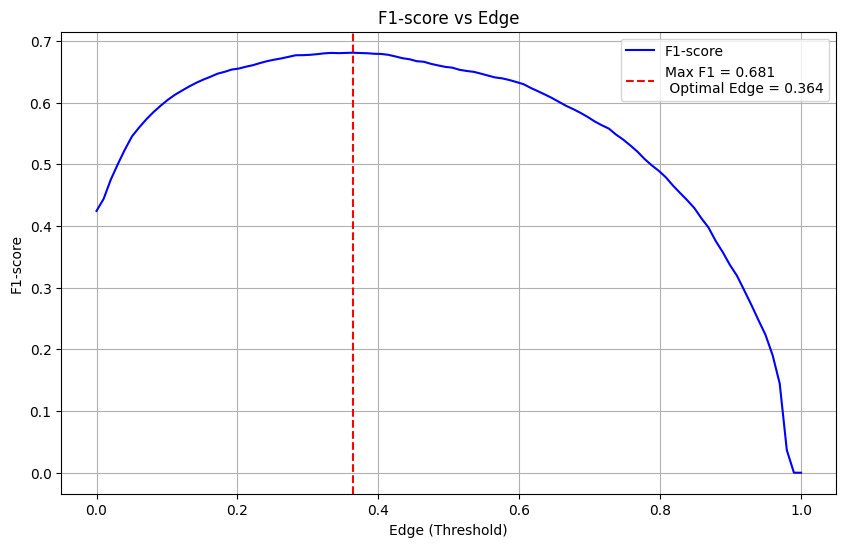

In [ ]:
# проверим гипотезу что граница уверенности в классе влияет на точность 

# Диапазон значений границы
edges = np.linspace(0, 1, 100)

# Список для хранения значений F1
f1_scores = []

# Рассчитываем F1-метрику для каждого значения edge
for edge in edges:
    outputs = outputs_ >= edge
    f1 = metrics.f1_score(targets, outputs, average='weighted')
    f1_scores.append(f1)

# Находим максимальное значение F1 и соответствующий edge
max_f1 = max(f1_scores)
optimal_edge = edges[np.argmax(f1_scores)]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(edges, f1_scores, label="F1-score", color="blue")
plt.xlabel("Edge (Threshold)")
plt.ylabel("F1-score")
plt.title("F1-score vs Edge")
plt.axvline(edges[np.argmax(f1_scores)], color='red', linestyle='--', label=f"Max F1 = {max(f1_scores):.3f} \n Optimal Edge = {optimal_edge:.3f}")
plt.legend()
plt.grid()
plt.show()

In [ ]:
outputs = np.array(outputs_) >= optimal_edge
print(metrics.classification_report(targets, outputs, target_names=labels,digits=4))

              precision    recall  f1-score   support

       anger     0.4972    0.6165    0.5504       717
     disgust     0.3716    0.5670    0.4490        97
        fear     0.3880    0.6762    0.4931       105
         joy     0.7647    0.8639    0.8113      2219
     sadness     0.4633    0.7615    0.5761       390
    surprise     0.5700    0.4696    0.5149       624
     neutral     0.6182    0.7446    0.6756      1766

   micro avg     0.6263    0.7418    0.6792      5918
   macro avg     0.5247    0.6713    0.5815      5918
weighted avg     0.6351    0.7418    0.6808      5918
 samples avg     0.6744    0.7571    0.6940      5918



c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ✏️ Получаем результаты на тесте

In [ ]:
test = load_dataset("csv", data_files={"test": "./content/test_without_answers.csv"})

In [ ]:
test = test.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           return_token_type_ids=True,
                                           padding="max_length"), batched=True)

test = test.map(one_hot_to_list)

In [ ]:
test_dataset = EmotionDataset(test["test"])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
outputs, _ = validation(model, criterion, test_dataloader)
outputs = np.array(outputs) >= optimal_edge

Valid loss: 0.35356713715259747


#### 🧑‍🍳 Готовим сабмит

In [ ]:
import pandas as pd

df = pd.read_csv("./content/test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [ ]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,0,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,0,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,0,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,0


In [ ]:
df.insert(loc=0, column='id', value=np.arange(1, len(df) + 1))
df = df.drop(['text'],axis=1)

In [ ]:
df[labels] = outputs.astype(int)

In [ ]:
df.head()

,id,anger,disgust,fear,joy,sadness,surprise,neutral
0,1,0,0,0,1,0,0,0
1,2,0,0,0,1,0,0,0
2,3,1,0,0,0,1,0,1
3,4,0,0,0,0,1,1,0
4,5,0,0,0,0,0,0,1


In [ ]:
df.to_csv("./content/submission_v5dj_036.csv", index=False)